Este notebook analisa o funcionamento dos modelos ARCH/GARCH e sua aplicação em previsão de volatilidade

Referências:

https://medium.com/@corredaniel1500/forecasting-volatility-deep-dive-into-arch-garch-models-46cd1945872b#:~:text=We%20make%20an%20assumption%20in,model%20errors%20are%20normally%20distributed.

https://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#ARCH

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

## Importação dos Dados
Os dados usados são de valores do mercado financeiro obtidos do pacote yfinance

In [5]:
spy = yf.Ticker("SPY")
hist = spy.history(start = "2010-01-04", end = "2020-02-01")
df = pd.DataFrame(hist, columns=['Close'])
df.head()

,Close
Date,
2010-01-04 00:00:00-05:00,87.483208
2010-01-05 00:00:00-05:00,87.714760
2010-01-06 00:00:00-05:00,87.776527
2010-01-07 00:00:00-05:00,88.147072
2010-01-08 00:00:00-05:00,88.440392


Uma transformação é aplicada para facilitar a análise da série. Ela consiste na diferenciação do log do valor de fechamento e obtenção do valor absoluto.

In [8]:
df['Retorno'] = np.pad(np.diff(np.log(df['Close'])) * 100, (1, 0), 'constant', constant_values=np.nan)
retorno_abs = df['Retorno'].abs()

A série é então exibida conforme abaixo.

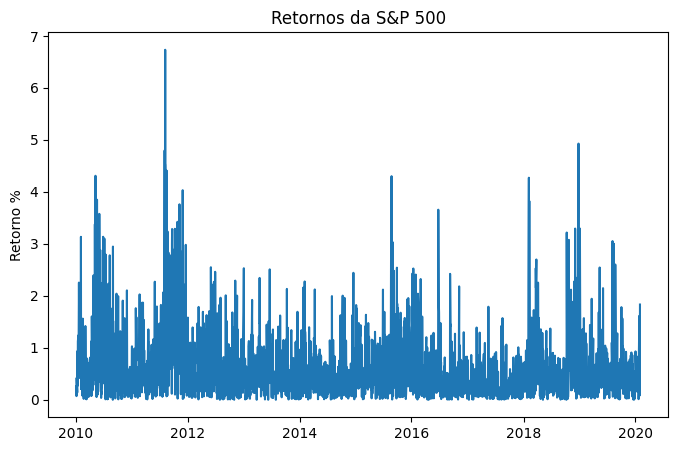

In [9]:
plt.figure(figsize=(8,5))
plt.plot(retorno_abs)
plt.ylabel("Retorno absoluto")
plt.title('Retornos da S&P 500');

O teste de McLeod-Li verifica se a série possui algum efeito ARCH, avaliando as seguintes hipóteses:

H₀: não parece haver efeito ARCH na série

Hₐ: parece haver efeito ARCH na série

In [10]:
from scipy.stats import chi2

def mcleod_li_test(x, k, cutoff=0.01):
    n = len(x)
    x_sq = x ** 2
    x_sum = np.sum(x_sq)
    x_lag_sum = np.sum(x_sq[:-k])
    test_stat = n * (n + 2) * x_lag_sum / (x_sum ** 2)
    df = k
    p_value = 1 - chi2.cdf(test_stat, df)

    if p_value < cutoff:
      print('Parece haver efeito ARCH nos dados')
    else:
      print('Não parece haver efeito ARCH nos dados')

    return test_stat, p_value

Testando a série de S&P, temos a indicação de que ocorrem mudanças na variância, ou seja, existe a presença de um modelo ARCH

In [11]:
test_stat, p_value = mcleod_li_test(retorno_abs, 50)
print("Teste McLeod-Li: ", test_stat)
print("p-value: ", p_value)

Parece haver efeito ARCH nos dados
Teste McLeod-Li:  2932.0631167050965
p-value:  0.0


## Ajuste e previsão de um modelo GARCH

Para este exemplo, escolheremos inicialmente um modelo GARCH(1,1), utilizando 80% da base para treinamento e 20% para o testes de previsão da volatilidade

In [13]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 7.0 MB/s eta 0:00:00


In [28]:
from sklearn.model_selection import train_test_split
from arch import arch_model

y_train, y_test = train_test_split(retorno_abs[1:], train_size= 0.8, shuffle=False)

garch_mod = arch_model(y_train, mean = "Zero",  vol='Garch', p=1, q=1, rescale=False)
res_garch = garch_mod.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4134.427076814227
Iteration:      2,   Func. Count:     14,   Neg. LLF: 3069.3101699879626
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3281.6526821511484
Iteration:      4,   Func. Count:     25,   Neg. LLF: 2411.9990432642326
Iteration:      5,   Func. Count:     30,   Neg. LLF: 2403.727860030128
Iteration:      6,   Func. Count:     34,   Neg. LLF: 2403.696911206399
Iteration:      7,   Func. Count:     38,   Neg. LLF: 2403.6939449444953
Iteration:      8,   Func. Count:     42,   Neg. LLF: 2403.693809721787
Iteration:      9,   Func. Count:     46,   Neg. LLF: 2403.6937465084234
Iteration:     10,   Func. Count:     49,   Neg. LLF: 2403.693746508514
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2403.6937465084234
            Iterations: 10
            Function evaluations: 49
            Gradient evaluations: 10


In [29]:
res_garch.summary

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:                Retorno   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2403.69
Distribution:                  Normal   AIC:                           4813.39
Method:            Maximum Likelihood   BIC:                           4830.23
                                        No. Observations:                 2028
Date:                Wed, Nov 08 2023   Df Residuals:                     2028
Time:                        03:23:54   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.

A função summary exibe, dentre outras informações, os parâmetros estimados para o modelo. No caso deste GARCH(1,1), os parâmetros omega, alpha e beta se referem, respectivamente, à constante, o coeficiente do lag e o coeficiente da variância passada.

###Previsão pelo modelo GARCH
Exemplo de previsão para horizonte de 1 passo

In [30]:
yhat = res_garch.forecast(horizon = 1, reindex=True)

Validação do modelo a partir do método rolling forecasting

In [35]:
rolling_preds = []

for i in range(y_test.shape[0]):
    train = retorno_abs[1:-(y_test.shape[0]-i)]
    model = arch_model(train, p=1, q=1, rescale = False)
    model_fit = model.fit(disp='off')
    # One step ahead predictor
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_preds.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_preds = pd.Series(rolling_preds, index=y_test.index)

Gráfico de previsão das volatilidades

Text(0.5, 1.0, 'S&P 500 Previsão de Volatilidade')

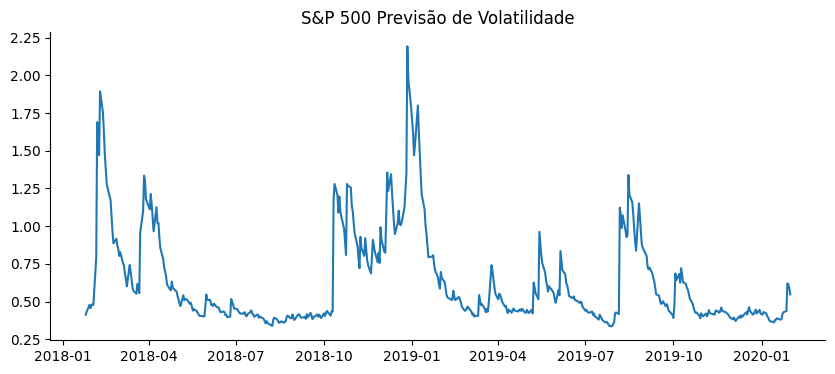

In [37]:
fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_preds)
plt.title('S&P 500 Previsão de Volatilidade')

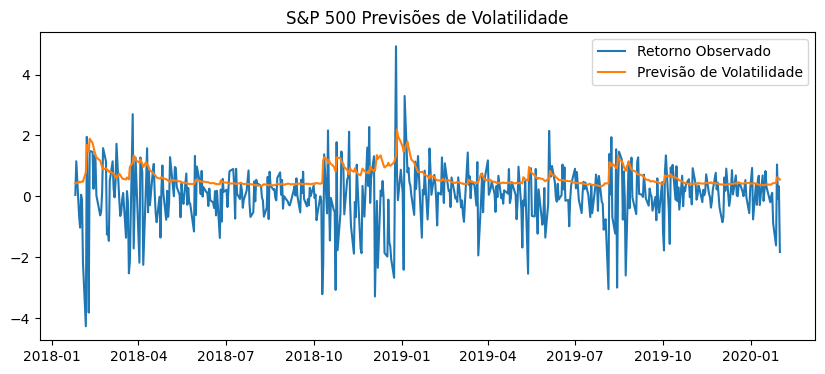

In [38]:
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(df['Retorno'][-y_test.shape[0]:])
ax.plot(y_test.index,rolling_preds)
ax.set_title("S&P 500 Previsões de Volatilidade")
ax.legend(['Retorno Observado', 'Previsão de Volatilidade'])
plt.show()

A figura acima indica um aumento nos valores de volatilidade exatamente nos terchos em que há uma maior variação nos valores máximos e mínimos da série. Isso indica que o modelo GARCH realizou algum ajuste sobre os dados.

## Avaliação do modelo

Ainda que visualmente tenhamos um indicativo de que o modelo está bem ajustado à série, é importante a utilização de métodos que possam avaliar o quão ajustado está o modelo, para eventualmente indicar melhorias nos parâmtetros escolhidos.

Um teste que pode auxiliar nessa atividade é o teste de Jarque-Bera. Este teste verifica se os residuos estão normalmente distribuídos, o que sugere que o modelo aplicado está bem ajustado aos dados. Para o exemplo observado acima, o teste pode ser aplicado da seguinte maneira:

In [39]:
from scipy.stats import jarque_bera

def teste_ajuste_jarque_bera(model, cutoff=0.01):
  # Calcula os resíduos obtidos a partir dos dados de teste
  std_resid = model.resid / model.conditional_volatility

  # Aplica o teste de Jarque-Bera
  jb_test = jarque_bera(std_resid)

  test_statistic = jb_test[0]
  p_value = jb_test[1]

  if p_value < cutoff:
    print("Resíduos não estão normalmente distribuídos. Portanto, o modelo pode necessitar de mais ajustes.", )
  else:
    print("Resíduos estão normalmente distribuídos. Portanto, o modelo parece estar bem ajustado.", )

  return test_statistic, p_value

In [40]:
teste_ajuste_jarque_bera(res_garch)

Resíduos não estão normalmente distribuídos. Portanto, o modelo pode necessitar de mais ajustes.


(1950.8601903077954, 0.0)

Para o exemplo realizado neste notebook, o teste inidica que podem ser necessários ajustes adicionais, sobretudo nos hiperparâmetros escolhidos.